# How to use

This notebook provides a step-by-step guide on how to use the implemented functionality.

# Setup

This section includes the necessary imports and initial configurations required to run the notebook.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
from config import get_config
config = get_config()
from models.ddpm import Denoiser, Diffusion

# Data Loading

Here, we load the dataset required for further processing and the model.

In [2]:
# Path to the trained model
#MODEL_PATH = "/your/path/here/checkpoints/ddpm.pth"
MODEL_PATH = "/pgeoprj/godeep/fhe1/frente-5-gan-experimentos/biGAN/Diffusion_Model/checkpoints/ddpm.pth"

# Device configuration: Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the denoising model
model = Denoiser(image_resolution=config["img_size"],
                 hidden_dims=config["hidden_dims"], 
                 diffusion_time_embedding_dim=config["timestep_embedding_dim"], 
                 n_times=config["n_timesteps"]).to(config["DEVICE"])

# Initialize the diffusion process
# Diffusion is responsible for generating new images using the trained model
diffusion = Diffusion(model, image_resolution=config["img_size"], n_times=config["n_timesteps"], 
                      use_cosine_schedule=True, device=config["DEVICE"]).to(config["DEVICE"])

# Evaluation

Here, we evaluate the model's performance on a validation/test dataset.

In [3]:
# Load the trained model parameters
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_3637505/1734094045.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Denoiser(
  (time_embedding): SinusoidalPosEmb()
  (in_project): ConvBlock(1, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_project): Sequential(
    (0): ConvBlock(
      256, 256, kernel_size=(1, 1), stride=(1, 1)
      (activation_fn): SiLU()
    )
    (1): ConvBlock(256, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (convs): ModuleList(
    (0): ConvBlock(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1-2): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation_fn): SiLU()
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
    )
    (3-4): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3)
      (activation_fn): SiLU()
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
    )
    (5-6): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(9, 9), dilation=(9, 9)
      (activation_fn): SiLU()
      (group_norm): Gro

# Image Generation Using the Trained Diffusion Model

This section demonstrates how to generate an image using the trained diffusion model. 

- The `generate_image` function takes the trained diffusion model and the device as inputs. It:
  - Disables gradient calculation (`torch.no_grad()`) to optimize inference.
  - Calls the `sample` method from the diffusion model to generate a single image.
  - Returns the generated image as a NumPy array after removing unnecessary dimensions.

- After generating the image, we display it using `matplotlib` with:
  - A grayscale colormap (`cmap="gray"`) to maintain consistency.
  - The axis turned off for a cleaner visualization.


/tmp/ipykernel_3637505/3785148485.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Loaded model from checkpoints/ddpm_epoch_0.pth
Loaded model from checkpoints/ddpm_epoch_100.pth
Loaded model from checkpoints/ddpm_epoch_200.pth


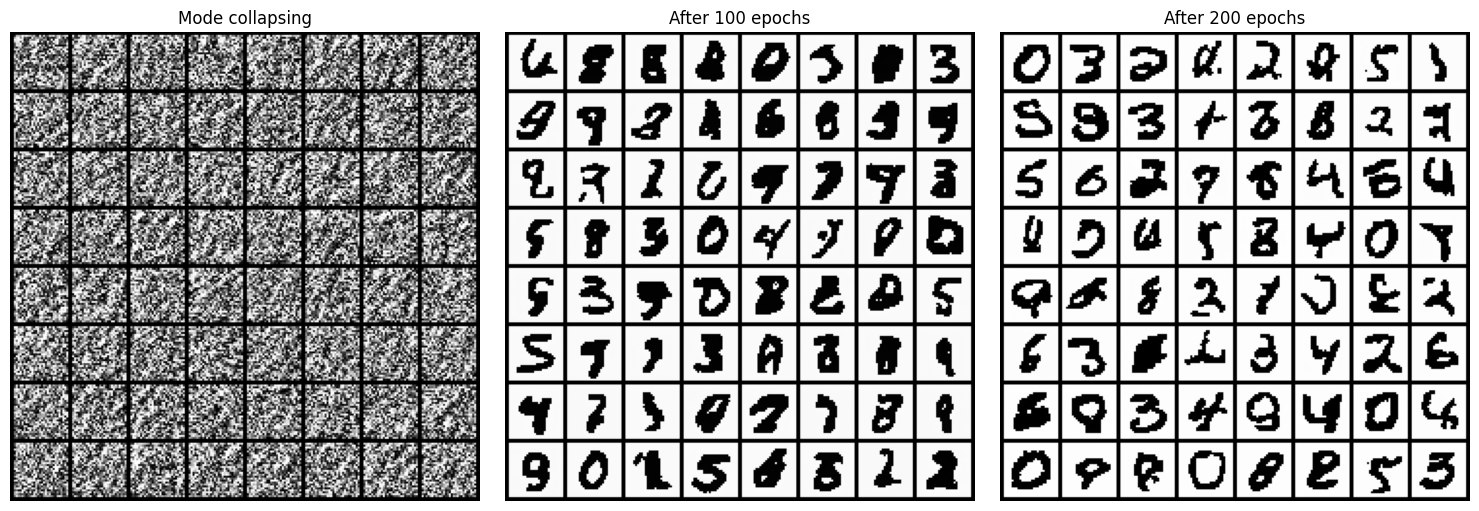

In [4]:
def load_model_at_epoch(model, epoch_checkpoint):
    """Loads the trained model from a specific checkpoint."""
    checkpoint_path = f"checkpoints/ddpm_epoch_{epoch_checkpoint}.pth"
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        print(f"Loaded model from {checkpoint_path}")
    else:
        print(f"Checkpoint {checkpoint_path} not found. Using the current model.")

def generate_images(diffusion, device, num_images=64):
    """Generates a batch of images using the trained model."""
    with torch.no_grad():
        generated_images = diffusion.sample(N=num_images)  # Generate a batch of images
        generated_images = generated_images.cpu()  # Transfer to CPU for visualization
        return generated_images

def draw_training_progress_images(model, diffusion, device):
    """Generates images and plots three columns to show the training progress."""

    # Load the model trained for 100 epochs and generate images
    load_model_at_epoch(model, 0)
    images_mode_collapse = generate_images(diffusion, device, num_images=64)

    # Load the model trained for 100 epochs and generate images
    load_model_at_epoch(model, 100)
    images_5_epochs = generate_images(diffusion, device, num_images=64)

    # Load the model trained for 200 epochs and generate images
    load_model_at_epoch(model, 200)
    images_10_epochs = generate_images(diffusion, device, num_images=64)

    # Create a figure with three different training stages
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ["Mode collapsing", "After 100 epochs", "After 200 epochs"]
    image_sets = [images_mode_collapse, images_5_epochs, images_10_epochs]

    for ax, title, img_set in zip(axes, titles, image_sets):
        grid = make_grid(img_set, nrow=8, padding=2, normalize=True)
        ax.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_training_progress_images(model, diffusion, device)